# Sco X1 injection recovery

In this notebook I plot posteriors recovered when looking at at Sco X1 software injection into S6 data. The injections were created as part of the [Sco X1 MDC](http://ukads.nottingham.ac.uk/abs/2015PhRvD..92b3006M) and we have recovered one that was created with a frequency of approximately 191.6 Hz. During the heterodyne stage I have purposely offset the frequency, right ascension, binary period, projected semi-major axis, and time of periastron from the known values of the injection. This has enabled me to test the the injection could still be recovered if these parameters were included in the search.

In [49]:
%matplotlib inline

import os
import sys

sys.path.append("/home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/lib/python2.7/site-packages")

import numpy as np
import itertools
import collections
import lalpulsar
from scotchcorner import scotchcorner as sc
import lalapps.pulsarpputils as pppu

from scipy import stats

In [12]:
# read in posterior files for the H1, L1 and joint analyses
posH1, BH1, NH1 = pppu.pulsar_nest_to_posterior('posterior_samples_J1619-1538B_H1.hdf')
posL1, BL1, NL1 = pppu.pulsar_nest_to_posterior('posterior_samples_J1619-1538B_L1.hdf')
posH1L1, BH1L1, NH1L1 = pppu.pulsar_nest_to_posterior('posterior_samples_J1619-1538B_H1L1.hdf')

asining SINI
Read columns ['A1', 'COSIOTA', 'F0', 'H0', 'PB', 'PHI0', 'PSI', 'RA', 'T0', 'deltalogL', 'deltaloglH1', 'logL', 'logPrior', 'logw', 'C22', 'A1_2', 'A1_3', 'DTHETA', 'ECC_3', 'DR', 'A0', 'DEC', 'B0', 'EPS2DOT', 'HVECTORY', 'PB_3', 'HPLUS', 'I21', 'I31', 'F0_FIXED', 'ECC_2', 'COSTHETA', 'GAMMA', 'FREQNUM', 'CGW', 'T0_3', 'MTOT', 'THETA', 'C21', 'HCROSS', 'PEPOCH', 'XPBDOT', 'df', 'EPS1', 'DIST', 'PHI22', 'PHI21', 'OM_3', 'OM_2', 'PHI0TENSOR', 'PBDOT', 'IOTA', 'OM', 'HSCALARL', 'EPS1DOT', 'POSEPOCH', 'HSCALARB', 'XDOT', 'M2', 'PX', 'PB_2', 'OMDOT', 'PMRA', 'LAMBDA', 'PMDEC', 'T0_2', 'PSIVECTOR', 'PSISCALAR', 'EDOT', 'EPS2', 'PHI0VECTOR', 'PSITENSOR', 'Q22', 'PHI0SCALAR', 'ECC', 'TASC', 'HVECTORX', 'I']
asining SINI
Read columns ['A1', 'COSIOTA', 'F0', 'H0', 'PB', 'PHI0', 'PSI', 'RA', 'T0', 'deltalogL', 'deltaloglL1', 'logL', 'logPrior', 'logw', 'C22', 'A1_2', 'A1_3', 'DTHETA', 'ECC_3', 'DR', 'A0', 'DEC', 'B0', 'EPS2DOT', 'HVECTORY', 'PB_3', 'HPLUS', 'I21', 'I31', 'F0_FIXED', 

In [20]:
# output the coherent signal versus noise odds
print("log10 Coherent signal vs noise odds = %.2f" % ((BH1L1-NH1L1)/np.log(10.)))

# output the coherent signal versus incoherent or noise odds
ifossn = [{'s': BH1, 'n': NH1}, {'s': BL1, 'n': NL1}]
combs = [list(i) for i in itertools.product(['s', 'n'], repeat=2)]
incoherentcombs = -np.inf
for comb in combs:
    combsum = 0.
    for i, cval in enumerate(comb):
        combsum += ifossn[i][cval]
    incoherentcombs = np.logaddexp(incoherentcombs, combsum)

bcins = BH1L1 - incoherentcombs
print("log10 Coherent signal vs incoherent signal or noise odds = %.2f" % (bcins/np.log(10.)))

log10 Coherent signal vs noise odds = 151.99
log10 Coherent signal vs incoherent signal or noise odds = 7.75


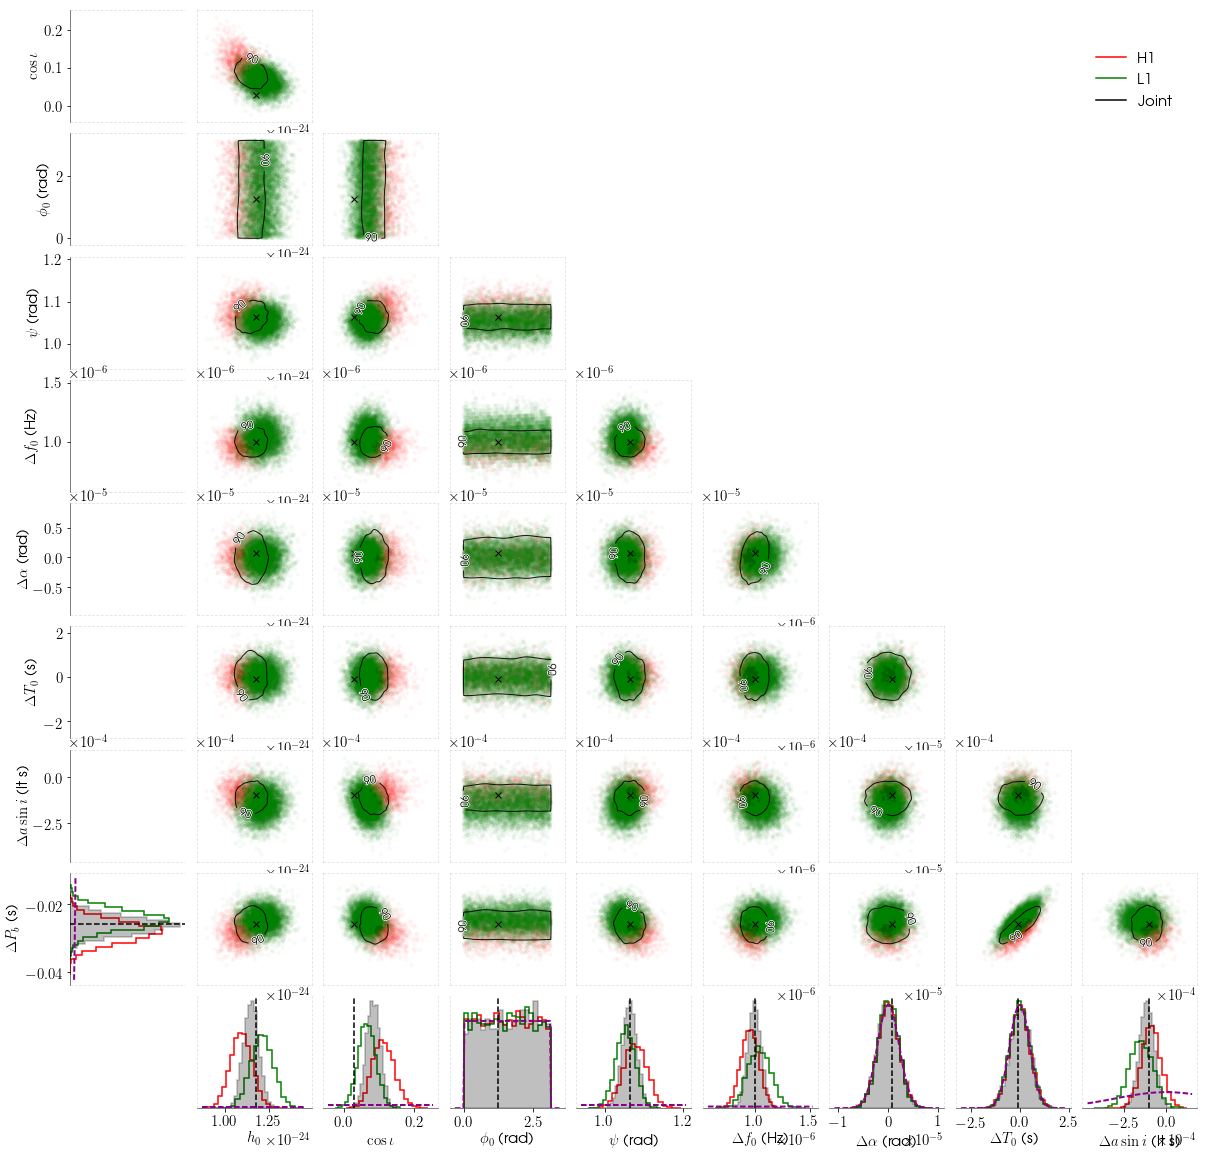

In [60]:
class fermidirac:
    def __init__(self, sigma, mu):
        self.sigma = sigma
        self.mu = mu

    def pdf(self, x):
        return 1./(self.sigma*np.log(1.+np.exp(self.mu/self.sigma))*(1.+np.exp((x-self.mu)/self.sigma)))

# create figure
ps = collections.OrderedDict()
ps['H0'] = r'$h_0$'
ps['COSIOTA'] = r'$\cos{\iota}$'
ps['PHI0'] = r'$\phi_0$ (rad)'
ps['PSI'] = r'$\psi$ (rad)'
ps['F0'] = r'$\Delta f_0$ (Hz)'
ps['RA'] = r'$\Delta \alpha$ (rad)'
ps['T0'] = r'$\Delta T_0$ (s)'
ps['A1'] = r'$\Delta a\sin{i}$ (lt s)'
ps['PB'] = r'$\Delta P_b$ (s)'

# values at which the heterodyne was performed
hetvals = [0., 0., 0., 0, 95.7901706944020, pppu.ra_to_rad('16:19:55.0752'), lalpulsar.TTMJDtoGPS(58664.9183995576528357), 1.518241776393, 0.7873119074637979*86400.]

# values at which the signal was injected
injvals = [1.176377713977e-24, 0.028716502110, 0.5*2.4928207662153965, 1.0641010321173106, 95.7901716944020, pppu.ra_to_rad('16:19:55.0850'), lalpulsar.TTMJDtoGPS(58664.9183985576528357), 1.518141776393, 0.7873116074637979*86400.]

priors = {}
priors[ps['H0']] = fermidirac(1.e-24, 1e-24*9.1625)
priors[ps['COSIOTA']] = stats.uniform(-1., 2.)
priors[ps['PHI0']] = stats.uniform(0., np.pi)
priors[ps['PSI']] = stats.uniform(0., np.pi/2.)
priors[ps['F0']] = stats.norm(0., 4e-6)
priors[ps['RA']] = stats.norm(0., 2.1816615649929116e-06)
priors[ps['T0']] = stats.norm(0., 5.1839999999999997e-01)
priors[ps['A1']] = stats.norm(0., 3e-4)
priors[ps['PB']] = stats.norm(0., 5.184e-2)

truths = []
for hv, iv in zip(hetvals, injvals):
    truths.append(iv-hv)

H1samps = []
L1samps = []
Jointsamps = []
for i, p in enumerate(ps):
    H1samps.append(posH1[p].samples - hetvals[i])
    L1samps.append(posL1[p].samples - hetvals[i])
    Jointsamps.append(posH1L1[p].samples - hetvals[i])

H1samps = np.array(H1samps).squeeze().T
L1samps = np.array(L1samps).squeeze().T
Jointsamps = np.array(Jointsamps).squeeze().T
    
limits = [(None, None), (None, None), (0., np.pi), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]

histops = {'histtype': 'step', 'color': 'r', 'edgecolor': 'r', 'linewidth': 1.5, 'alpha': 1.0}
contourops = {'colors': 'darkblue'}

spp = sc(H1samps, bins=20, ratio=1, labels=ps.values(), datatitle='H1', showlims='both', hist_kwargs=histops,
         showcontours=False, limits=limits, showpoints=True, scatter_kwargs={'alpha': 0.03},
         contour_limits=limits, contour_kwargs=contourops, thinpoints=6)

histops = {'histtype': 'step', 'color': 'g', 'edgecolor': 'g', 'linewidth': 1.5, 'alpha': 1.0}
spp.add_data(L1samps, hist_kwargs=histops, datatitle='L1', scatter_kwargs={'alpha': 0.03}, showcontours=False,
            limits=limits, contour_kwargs=contourops, contour_limits=limits)

histops = {'histtype': 'stepfilled', 'color': 'k', 'edgecolor': 'k', 'linewidth': 1.5, 'alpha': 0.25}
contourops = {'colors': 'black'}
spp.add_data(Jointsamps, hist_kwargs=histops, datatitle='Joint', scatter_kwargs={'alpha': 0.03}, showcontours=True,
            limits=limits, contour_kwargs=contourops, contour_limits=limits, truths=truths, showpoints=False,
            truths_kwargs={'color': 'k', 'linestyle': '--'}, contour_levels=[0.9])

# plot priors
for i, lab in enumerate(ps.values()):
    ax = spp.get_axis(lab)
    
    if i < len(ps.values())-1:
        lims = ax.get_xlim()
    else:
        lims = ax.get_ylim()

    pvals = np.linspace(lims[0], lims[1], 100)
    pdf = priors[lab].pdf(pvals)

    if i < len(ps.values())-1:
        ax.plot(pvals, pdf, color='darkmagenta', linestyle='--', lw=2)
    else:
        ax.plot(pdf, pvals, color='darkmagenta', linestyle='--', lw=2)

In [61]:
import subprocess as sp

spp.savefig('scox1_inj.pdf')
spp.fig.savefig('scox1_inj.png', dpi=300)

p = sp.Popen('pdftops -eps %s' % 'scox1_inj.pdf', shell=True)
p.communicate()

caption = r"""\label{fig:scox1_inj}
Marginalised posterior plots for the recovered parameters of a simulated binary signals (with binary parameters
similar to those of Sco X-1) using simulated LIGO H1 (red) and L1 (green) data, including a joint detector analysis
(grey). The location of the simulated signal parameters are marked with a vertical black dash line or black
cross. The priors used for each parameter are shown as the dark magenta dashed lines.
"""

fp = open('caption.tex', 'w')
fp.write(caption)
fp.close()